## Sales Forecastin using SARIMAX

The general process for forecasting models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the forecasting model based on the data
* Use the model to make predictions

Let's go through these steps!

#### Step1 : Import required dependencies

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import  STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
%matplotlib inline

#### Step 2: Load the dataset

In [17]:
df = pd.read_csv('sales.csv')
df.dropna(inplace=True)
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


##### --visualise the dataset

<Axes: >

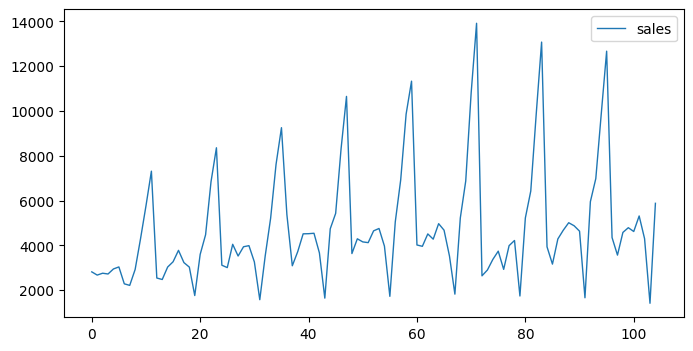

In [5]:
df.rename(columns={'Month': 'month'}, inplace=True)
df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'sales'}, inplace=True)
df.plot(figsize=(8,4), lw=1)

#### Step 3: Decompose the series to analyse trend, seasonality, and residual(noise)

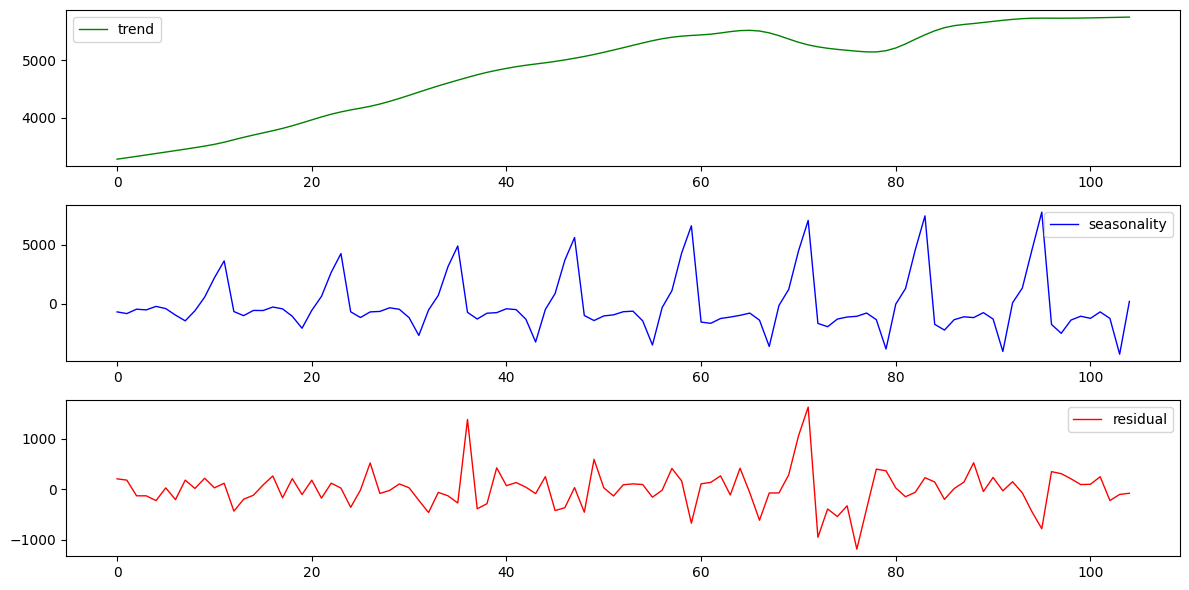

In [6]:
stl= STL(df['sales'], period=12)
result = stl.fit()
trend = result.trend
seasonality = result.seasonal
resid = result.resid

fig, axs = plt.subplots(3,1, figsize=(12,6))
axs[0].plot(trend, color='green', label='trend', lw=1)
axs[0].legend(loc='best')

axs[1].plot(seasonality, color='blue', label='seasonality', lw=1)
axs[1].legend(loc='best')

axs[2].plot(resid, color='red', label='residual', lw=1)
axs[2].legend(loc='best')

plt.tight_layout()
plt.show()

#### Step 4: Check stationarity with adf test (or kpss, rolling mean etc)

In [7]:
result = adfuller(df['sales'].dropna())
print('ADF test results: ')
print(f"ADF statistics: {round(result[0],3)}")
print(f"'p-value: {round(result[1],3)}")
print('Critica values: ')
for key, value in result[4].items():
    print(f"  {key}: {round(value,3)}")
if(round(result[1],3) < 0.05):
    print("the adf testing shows that data is stationary")
else:
    print('data is not stationary')

ADF test results: 
ADF statistics: -1.834
'p-value: 0.364
Critica values: 
  1%: -3.503
  5%: -2.893
  10%: -2.584
data is not stationary


#### Step 5: Make series stationary if not
we can use various techniques:
* differencing
* rolling mean average
* removing trend..etc

In [8]:
# we are differencing the series with 12 steps as seasonality is repeating every 12 months 
df["stationary"] = df["sales"] - df['sales'].shift(12)
df.head(20)

,month,sales,stationary
0,1964-01,2815.0,NaN
1,1964-02,2672.0,NaN
2,1964-03,2755.0,NaN
3,1964-04,2721.0,NaN
4,1964-05,2946.0,NaN
5,1964-06,3036.0,NaN
6,1964-07,2282.0,NaN
7,1964-08,2212.0,NaN
8,1964-09,2922.0,NaN
9,1964-10,4301.0,NaN


In [9]:
# remove null values 
df.dropna(inplace=True)
df.head(20)

,month,sales,stationary
12,1965-01,2541.0,-274.0
13,1965-02,2475.0,-197.0
14,1965-03,3031.0,276.0
15,1965-04,3266.0,545.0
16,1965-05,3776.0,830.0
17,1965-06,3230.0,194.0
18,1965-07,3028.0,746.0
19,1965-08,1759.0,-453.0
20,1965-09,3595.0,673.0
21,1965-10,4474.0,173.0


#### Step 6: Find order of the series by plotting ACF & PACF plot
* acf plot will show decay, acf gives q value at point of decay
* pacf plot will show a strong cutoff, which will give p value

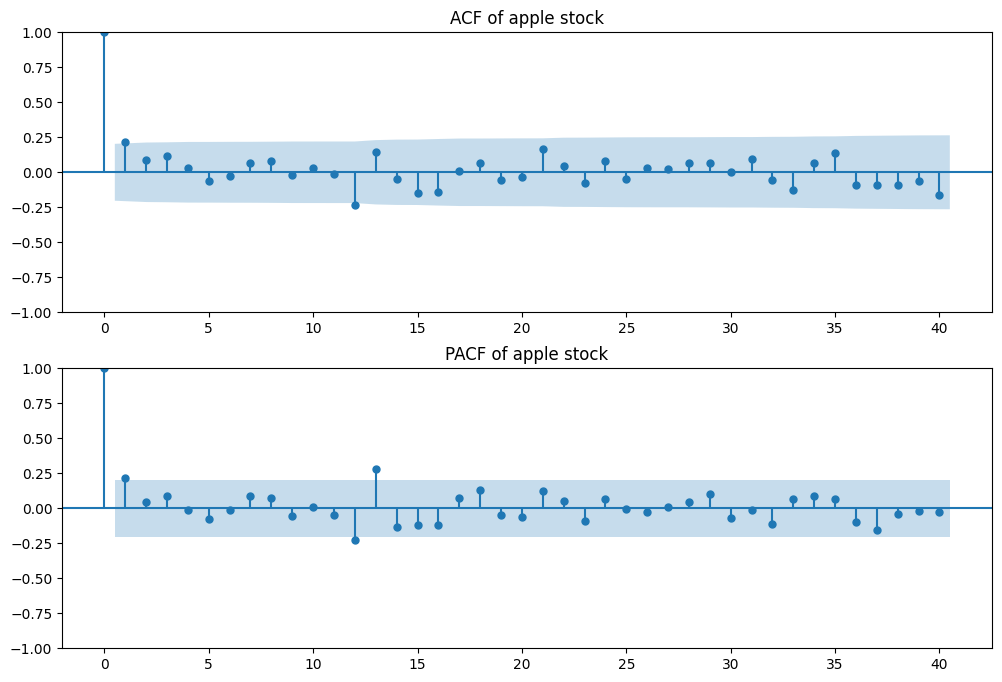

In [10]:
fig,axs = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['stationary'], ax=axs[0], lags=40)
axs[0].set_title('ACF of apple stock')
# PACF plot
plot_pacf(df['stationary'], lags=40,ax=axs[1], method='ywm')
axs[1].set_title('PACF of apple stock')
plt.show()

* As acf graph show a very negligible decay, we can choose 0 or 1 for q value
* pacf graph shows cutoff at the value 1, so p will be 1
* we get d from the order of differencing, here d =1

* so the final order of the model will be (1,1,1)

#### Step 7: We will use SARIMAX model as the series has seasonality
* for sarimax model seasonal order will be same as normal order i.e.: (1,1,1) with period 12

In [11]:
model = SARIMAX(df['sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit()

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


* we will store forcasted values in a column of the dataframe 
* we will also plot graph of forecasted values against the actual values

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


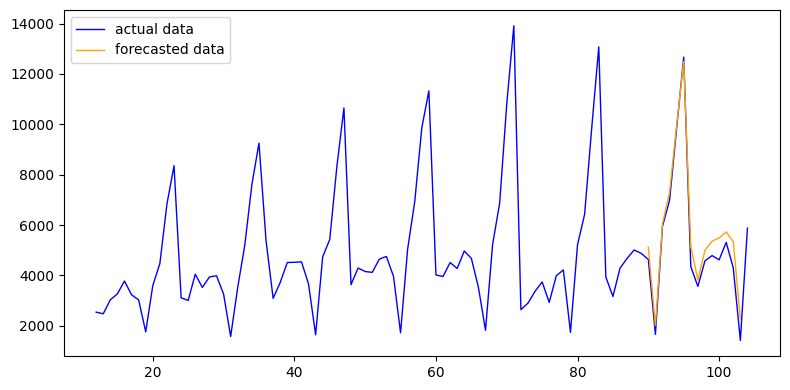

In [15]:
df['forecast'] = result.predict(start=90, end=103, dynamic=True)

plt.figure(figsize=(8,4))
plt.plot(df['sales'], color='blue', label='actual data', lw=1)
plt.plot(df['forecast'], color='orange', label='forecasted data', lw=1)
plt.legend(loc='best')
plt.tight_layout()
plt.show()